In [1]:
import pandas as pd

brent_oil_df_raw = pd.read_csv("data/GasOtherFutures/individual_data/Brent_Crude_Oil_data.csv")
display(brent_oil_df_raw)

,date,open,high,low,close,volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,4387
...,...,...,...,...,...,...
4130,2024-03-19,86.849998,87.709999,86.489998,87.379997,30045
4131,2024-03-20,87.220001,87.349998,85.580002,85.949997,35304
4132,2024-03-21,86.160004,86.639999,85.050003,85.779999,23829
4133,2024-03-22,85.550003,86.150002,85.110001,85.430000,14778


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Decorator to handle 1D array cases
def handle_1d_array(func):
    def wrapper(self, X: np.ndarray):
        flatten = False
        if X.ndim == 1:
            flatten = True
            X = X.reshape(-1, 1)
        res = func(self, X)
        if isinstance(res, np.ndarray) and flatten:
            res = res.flatten()
        return res
    return wrapper


# MinMaxScaler version that already deals with 1D array cases
class MMinMaxScaler(MinMaxScaler):
    @handle_1d_array
    def fit_transform(self, X: np.ndarray):
        return super().fit_transform(X)
    
    @handle_1d_array
    def transform(self, X: np.ndarray):
        return super().transform(X)
    
    @handle_1d_array
    def inverse_transform(self, X: np.ndarray):
        return super().inverse_transform(X)
    
    @handle_1d_array
    def fit(self, X: np.ndarray):
        return super().fit(X)

In [3]:
import numpy as np

data = np.full((brent_oil_df_raw['date'].size, 4), np.nan)
close_columns = pd.MultiIndex.from_product([['Close value'], ['Original', 'Predicted'], ['Scaled', 'Normalized']])
brent_oil_close_df = pd.DataFrame(
    data,
    index=pd.to_datetime(brent_oil_df_raw['date']),
    columns=close_columns)
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Scaled')] =\
    brent_oil_df_raw['close'].to_numpy()
scaler_ = MMinMaxScaler().fit(brent_oil_df_raw['close'].to_numpy())
brent_oil_close_df.loc[:, ('Close value', 'Original', 'Normalized')] =\
    scaler_.transform(brent_oil_df_raw['close'].to_numpy())
brent_oil_close_df.attrs['scaler'] = scaler_
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-19   87.379997   0.536884       NaN        NaN
2024-03-20   85.949997   0.525602       NaN        NaN
2024-03-21   85.779999   0.524260       NaN        NaN
2024-03-22   85.430000   0.521499       NaN        NaN
2024-03-25   86.730003   0.531755       NaN        NaN

[4135 rows x 4 columns]

In [4]:
# Using business day frequency
brent_oil_close_df = brent_oil_close_df.asfreq('B')
brent_oil_close_df.interpolate('time', inplace=True)
brent_oil_close_df

Close value                                
              Original            Predicted           
                Scaled Normalized    Scaled Normalized
date                                                  
2007-07-30   75.739998   0.445049       NaN        NaN
2007-07-31   77.050003   0.455385       NaN        NaN
2007-08-01   75.349998   0.441972       NaN        NaN
2007-08-02   75.760002   0.445207       NaN        NaN
2007-08-03   74.750000   0.437239       NaN        NaN
...                ...        ...       ...        ...
2024-03-19   87.379997   0.536884       NaN        NaN
2024-03-20   85.949997   0.525602       NaN        NaN
2024-03-21   85.779999   0.524260       NaN        NaN
2024-03-22   85.430000   0.521499       NaN        NaN
2024-03-25   86.730003   0.531755       NaN        NaN

[4346 rows x 4 columns]

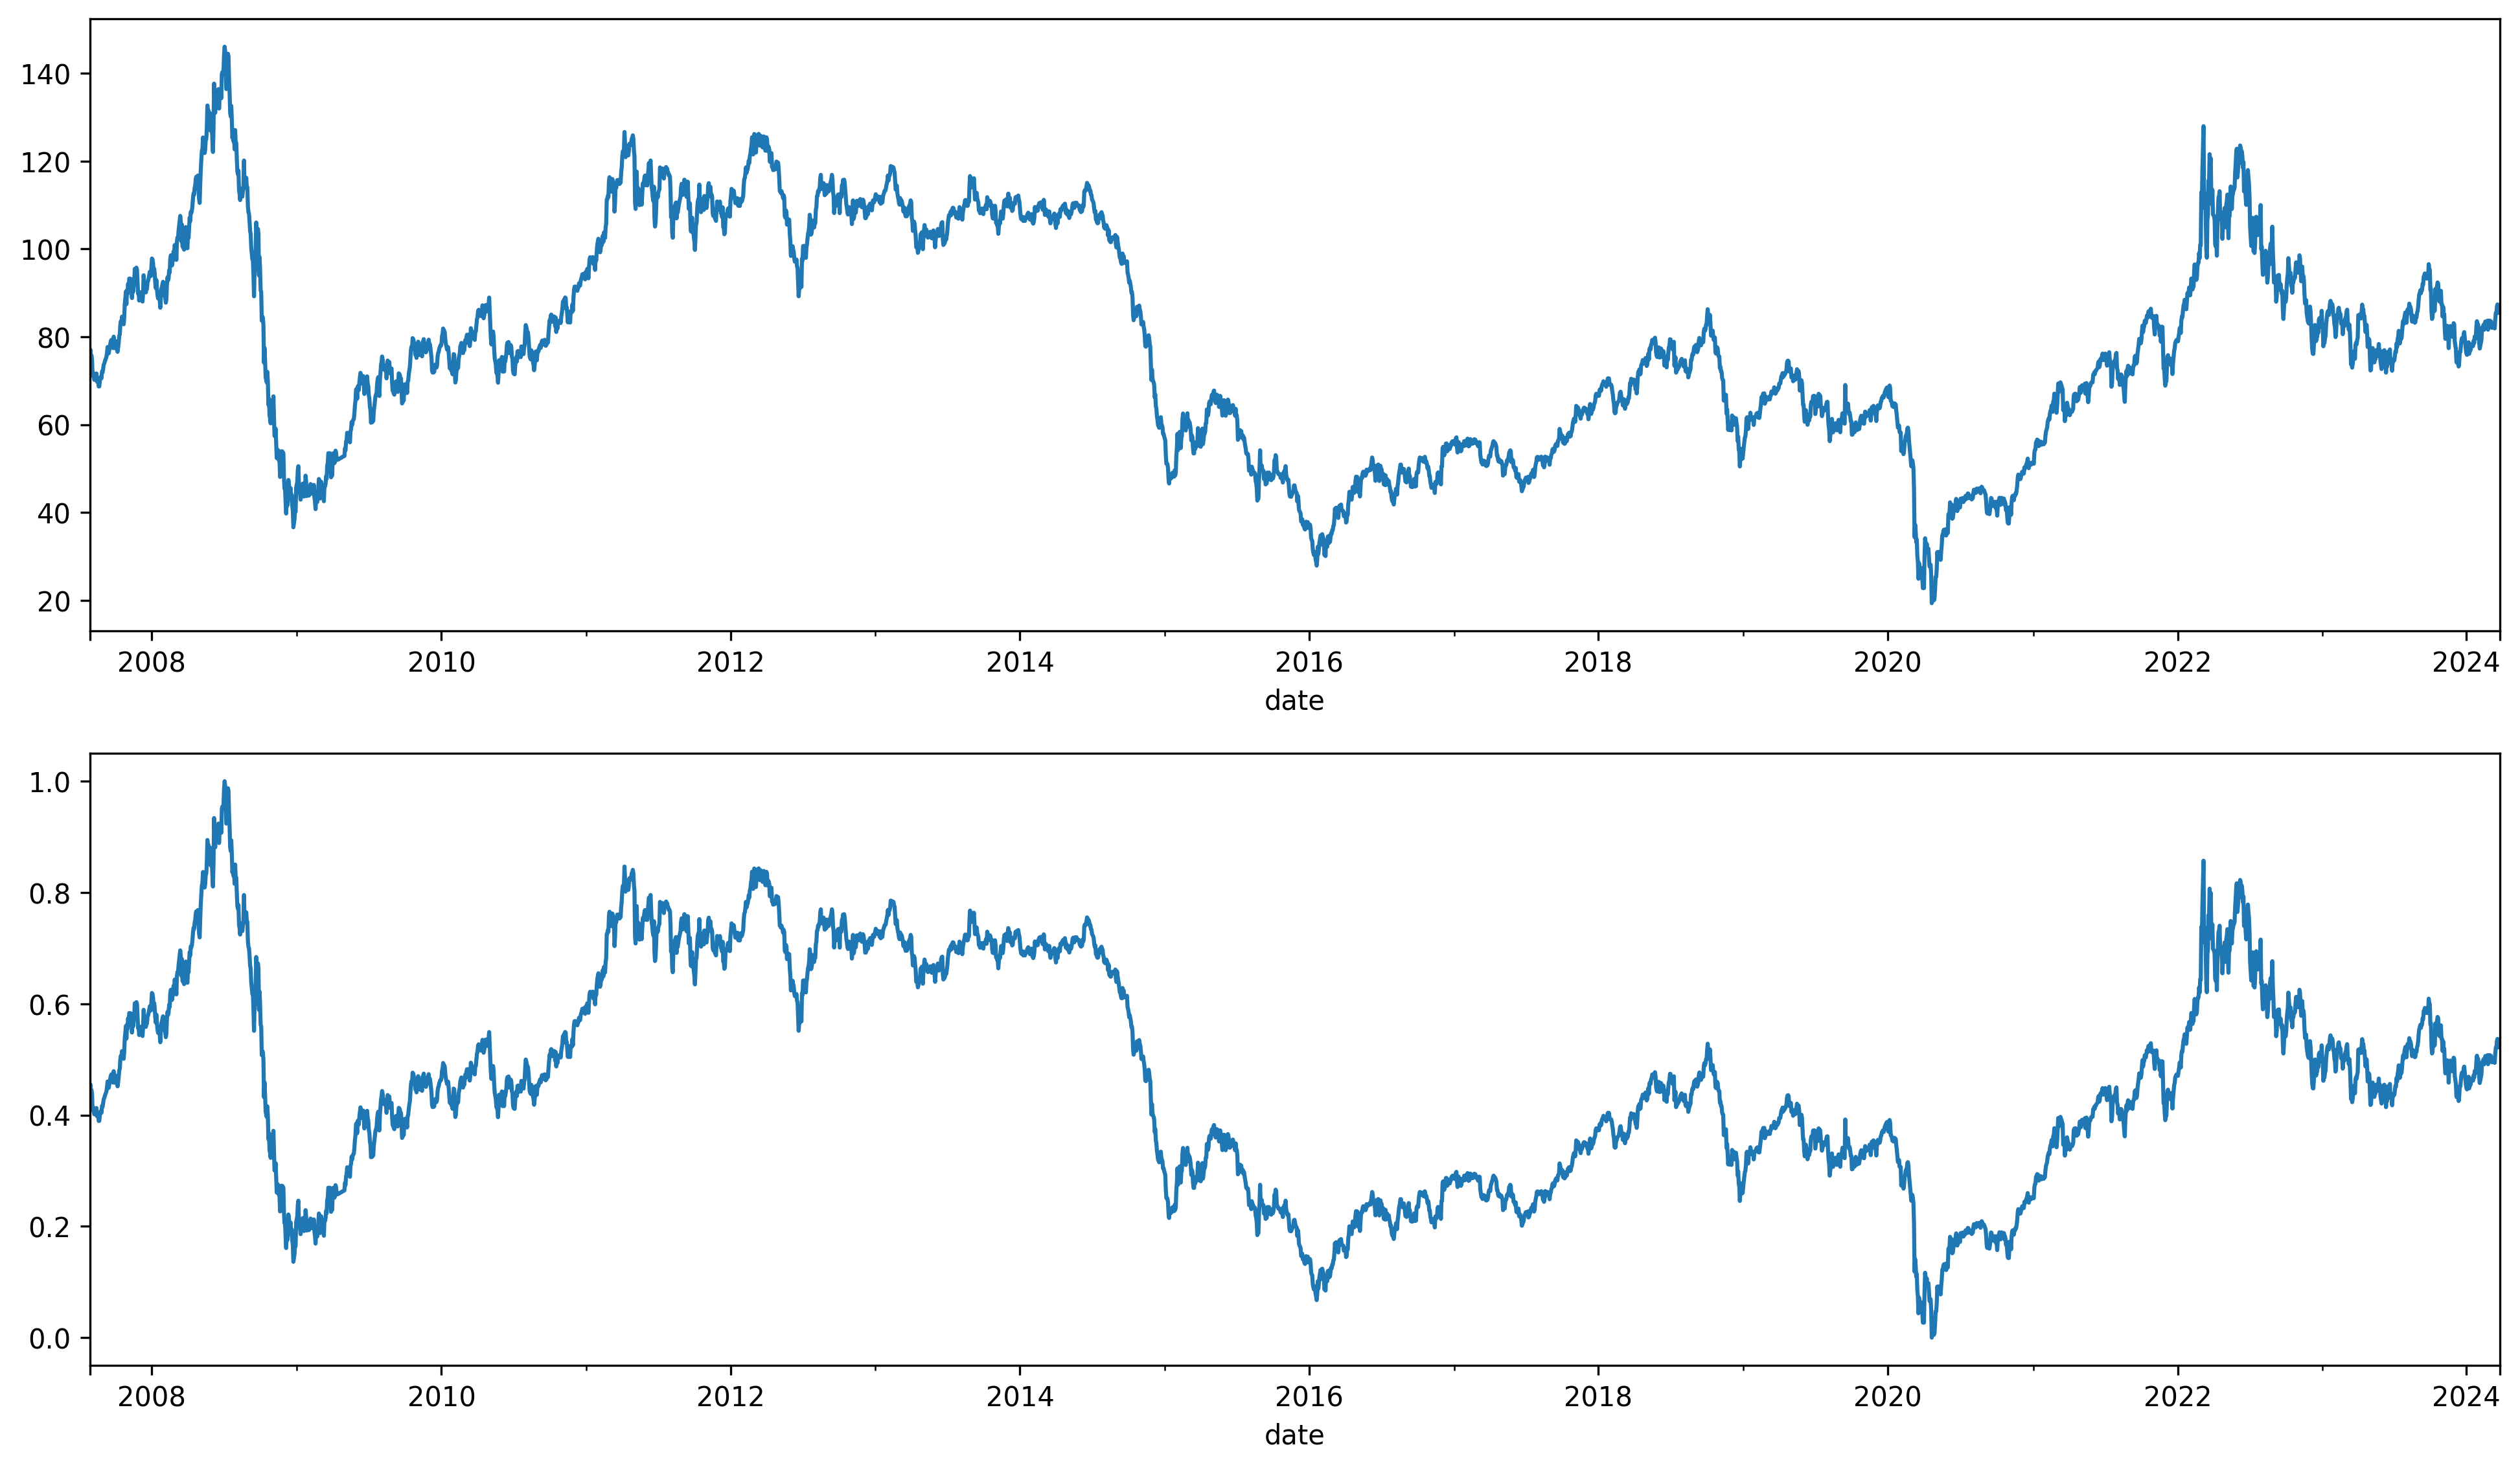

In [5]:
import matplotlib.pyplot as plt

# Comparing plots for scaled and normalized data (should look the same)
fig, axs = plt.subplots(2, 1, figsize=(16, 9))
brent_oil_close_df['Close value']['Original']['Scaled'].plot(ax=axs[0])
brent_oil_close_df['Close value']['Original']['Normalized'].plot(ax=axs[1])
plt.gcf().set_dpi(300)
plt.show()

In [6]:
class TimeSeriesHandler:
    def __init__(self):
        self.operations = []
    
    def _split(self, data: np.ndarray) -> dict[str, np.ndarray]:
        if not isinstance(data, np.ndarray):
            raise ValueError("Data must be a numpy array")
        if self.test_split is None:
            raise ValueError("Test split not set")
        split = int(len(data) * self.test_split)
        return {
            "train": data[:-split],
            "test": data[-split:]
        }
    
    def _sequence(
        self,
        data: np.ndarray | dict[str, np.ndarray]
    ) -> dict[str, np.ndarray]:
        if isinstance(data, dict):
            train_split = self._sequence(data["train"])
            test_split = self._sequence(data["test"])
            return {
                "x_train": train_split["x"],
                "y_train": train_split["y"],
                "x_test": test_split["x"],
                "y_test": test_split["y"]
            }
        if not isinstance(data, np.ndarray):
            raise ValueError("Data must be a numpy array")
        x = np.array([
            data[i : i + self.prev] for i in range(len(data) - self.sequence_size)
        ])
        y = np.array([
            data[i + self.prev : i + self.sequence_size] for i in range(len(data) - self.sequence_size)
        ])
        return {
            "x": x,
            "y": y
        }

    def prepare_split(self, test_split: float):
        self.test_split = test_split
        if self._sequence in self.operations:
            raise ValueError("Cannot split after sequence transformation")
        elif self._split in self.operations:
            raise ValueError("Cannot split after split transformation")
        self.test_split = test_split
        self.operations.append(self._split)
        return self

    def prepare_sequences(self, prev: int, future: int):
        if self._sequence in self.operations:
            raise ValueError("Cannot sequence after sequence transformation")
        self.prev = prev
        self.future = future
        self.sequence_size = prev + future
        self.operations.append(self._sequence)
        return self
    
    def get_transformed(self, data: np.ndarray):
        transformed = data
        for op in self.operations:
            transformed = op(transformed)
        return transformed

$$
y_t = \theta_1 y_{t-3} + \theta_2 y_{t-3}^2 + \theta_3 y_{t-2} + \theta_4 y_{t-2}^2 + \theta_5 y_{t-1} + \theta_6 y_{t-1}^2
$$

WIP: implementar isso.

In [7]:
from sklearn.svm import SVR

handler = TimeSeriesHandler().prepare_split(0.2).prepare_sequences(10, 5)
prepared_data = handler.get_transformed(brent_oil_close_df['Close value']['Original']['Normalized'].to_numpy())
indexes_partition = handler.get_transformed(brent_oil_close_df.index.to_numpy())

SVR(C=10, epsilon=0.05, gamma=0.5)